# Assignment 3: Image Classification

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Question 1. Data (20%)

Download the data from the course website. 

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [ ]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck

def feat(filename):
  """Compute the number of triplets, the number of pairs of shoes from each triplet.
     It also computes the left or right shoe.
     This function returns three values for each file name.
    """
  person = filename.split("_")[0][1:]
  if person[0] == '0':
    person = person[1:]
    if person[0] == '0':
      person = person[1:]
  pair = filename.split("_")[1]
  side = filename.split("_")[2]
  if side == 'left':
    side = 0
  elif side == 'right':
    side = 1
  return [int(person)-1,int(pair)-1,side]

def find_N(dict_data):
    """This function returns the number of the triplet with the biggest person number.
    """
    n = []
    for key, value in dict_data.items():
      n.append(feat(key)[0])
      N = np.max(n)+1
    return N

def make_list(dict_data):
    """This function returns a numpy array of the images organized by triplets,
     each triplet contains 3 pairs of shoe images.
     The size of the array returned is: N,3,2,H,W,C
     Where N is the number of triplets, H is the height, W is the weight, 
     and C is the number of channels of each image. 
    """
    n = find_N(dict_data)
    temp = np.zeros((n,3,2,224,224,3))
    for key, value in dict_data.items():
      per = feat(key)[0]
      pair = feat(key)[1]
      side = feat(key)[2]
      temp[per][pair][side] = value
    tmp2 = []
    for person in temp:
      if person.all() != 0:
        tmp2.append(person)
    return np.array(tmp2)

In [ ]:
# reading files
import glob
path = "/content/gdrive/My Drive/Colab Notebooks/data/*/*.jpg" # TODO - UPDATE ME!

train_dict = {}
test_m_dict = {}
test_w_dict = {}
for file in glob.glob(path):
    if file.split("/")[-2] == 'train':
      filename = file.split("/")[-1]   # get the name of the .jpg file
      img = plt.imread(file)           # read the image as a numpy array
      img = np.subtract(np.divide(img,255),0.5)
      train_dict[filename] = img[:, :, :3] # remove the alpha channel
    elif file.split("/")[-2] == 'test_w':
      filename = file.split("/")[-1]   # get the name of the .jpg file
      img = plt.imread(file)           # read the image as a numpy array
      img = np.subtract(np.divide(img,255),0.5)
      test_w_dict[filename] = img[:, :, :3] # remove the alpha channel
    elif file.split("/")[-2] == 'test_m':
      filename = file.split("/")[-1]   # get the name of the .jpg file
      img = plt.imread(file)           # read the image as a numpy array
      img = np.subtract(np.divide(img,255),0.5)
      test_m_dict[filename] = img[:, :, :3] # remove the alpha channel

train = make_list(train_dict)
test_w = make_list(test_w_dict)
test_m = make_list(test_m_dict)

train_data = train[:92,:,:,:,:,:]
valid_data = train[92:,:,:,:,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


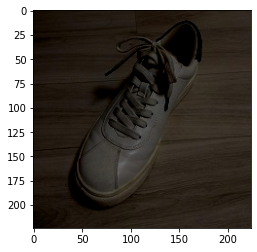

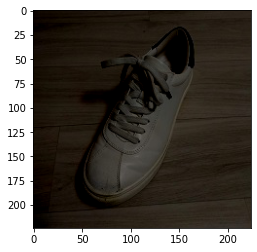

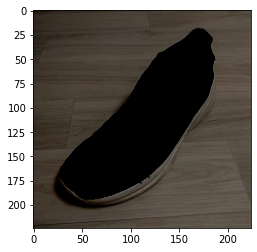

In [ ]:
## Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(92, 3, 2, 224, 224, 3)
(276, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


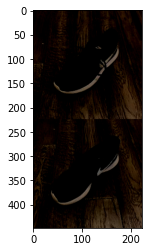

In [ ]:
def generate_same_pair(data):
  temp = []
  for p in range(data.shape[0]):
      for s in range(3):
        temp.append(np.concatenate((data[p,s,0,:,:],data[p,s,1,:,:])))
  return np.array(temp)

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(92, 3, 2, 224, 224, 3)
(276, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


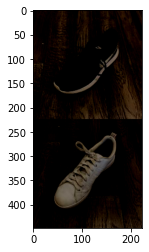

In [ ]:
def generate_different_pair(data):
  temp = []
  for p in range(data.shape[0]):
      temp.append(np.concatenate((data[p,0,0,:,:],data[p,1,1,:,:])))
      temp.append(np.concatenate((data[p,0,0,:,:],data[p,2,1,:,:])))
      temp.append(np.concatenate((data[p,1,0,:,:],data[p,2,1,:,:])))    
  return np.array(temp)

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Explanation:** 

We would like that the different pairs of shoes will come from the same person because different persons have different images background and different photo conditions. Therefore, if we take pairs of shoes from different persons the model will classify it as a negative example not only because of the differences of the shoe's pixels but mostly because of the different background’s pixels. so, the model will have difficulty classifying pair of shoes from the same person because of the high correlations between the pixels of the image's background although the pair of shoes itself is different.

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Explanation:**
Training the model with an imbalanced dataset will cause a problematic model that has difficulty classifying positive examples. Such a model will probably classify images of shoes that are from the same pair as negative examples because it hasn’t been trained on such pairs.

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [ ]:
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(8*n*28*14, 100)
        self.fc2 = nn.Linear(100, 2)
        self.dropout = nn.Dropout(0.25)
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)
        x = x.view(-1, self.n*28*14*8)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [ ]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=n, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*n*14*14, 100)
        self.fc2 = nn.Linear(100, 2)
        self.dropout = nn.Dropout(0.25)
    def forward(self, x, verbose=False):
        #x = torch.transpose(x,2,3)
        x1 = x[:,:,:224,:]
        x2 = x[:,:,224:,:]
        x = torch.cat((x1,x2),dim=1)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)
        x = x.view(-1, self.n*14*14*8)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Explanation:** 

Natural image signals typically exhibit the locality property which means that nearby pixels are more correlated than pixels far away. In our case, we want the pixels of each image in pair of shoes to be close to one another so that the model will use the locality property and make predictions due to the similarity of the correlated points. In the first model, the correlated points of each pair of shoes are far away from each other, unlike the second model where the correlated point are one above the other, so the convolution involves the channels dimensions of both images in each pair of shoes. We can conclude that the model CNNChannel performs better.

## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Explanation:**

Our models get two types of images- negative samples and positive samples.
We want to compute the accuracy on the positive and negative samples separately so we will know if the models have been treated differently to each type of sample,  how good our models are for each type, and make sure that the accuracy is not computed only for one type of sample.

In [ ]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]
    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3)    # shape [n * 3, 3, 224, 448]
        xs = torch.transpose(xs,2,3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
        
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3)
        xs = torch.transpose(xs,2,3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()
    
    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [ ]:
def get_batch(pos,neg,min_range,max_range):
    """This function returns:
    xt - the input data of the positive samples and the negative samples.
    st - the labels of ones for positive samples, and the lables of zeros for the negative samples.
    In the train function, we use min_range and max_range to define the batch size divided by two.
    """
    xt = np.concatenate((pos[min_range:max_range,:,:,:],neg[min_range:max_range,:,:,:]))
    st = np.concatenate((np.ones(max_range-min_range),np.zeros(max_range-min_range)))
    reindex = np.random.permutation((max_range-min_range)*2)
    return xt[reindex], st[reindex]

def train_model(model,
                train_data=train_data,
                validation_data=valid_data,
                batch_size=100,
                learning_rate=0.001,
                weight_decay=0,
                max_iters=1000,
                checkpoint_path=None):
  
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    iters, losses = [], []
    iters_sub, train_accs_pos, train_accs_neg, valid_accs_pos, valid_accs_neg = [], [] ,[] ,[] ,[] 
    # Get positive and negative data
    pos = generate_same_pair(train_data)
    neg = generate_different_pair(train_data)
    
    n = 0 # the number of iterations
    while True:
      #Reindex by one to one permutation.
      reindex = np.random.permutation(len(pos))
      pos = pos[reindex]
      #Reindex by one to one permutation.
      reindex = np.random.permutation(len(neg))
      neg = neg[reindex]
      size = pos.shape[0]
      for i in range(0, size, int(batch_size/2)):
          if (i + int(batch_size/2)) > size:
              break

          # get the input and targets of a minibatch
          xt, st = get_batch(pos,neg, i, i + int(batch_size/2))

          # convert from numpy arrays to PyTorch tensors
          xt = torch.Tensor(xt).transpose(1, 3)
          xt = torch.transpose(xt,2,3)
          st = torch.Tensor(st).long()

          zs = model(xt)                  # compute prediction logit
          loss = criterion(zs,st)         # compute the total loss
          optimizer.zero_grad()           # a clean up step for PyTorch
          loss.backward()                 # compute updates for each parameter
          optimizer.step()                # make the updates for each parameter
                                

          # save the current training information
          iters.append(n)
          losses.append(float(loss)/batch_size)  # compute *average* loss
          if n % 25 == 0:
              iters_sub.append(n)
              train_cost = float(loss.detach().numpy())
              pos_acc_t, neg_acc_t = get_accuracy(model, train_data, batch_size = batch_size)
              train_accs_pos.append(pos_acc_t)
              train_accs_neg.append(neg_acc_t)
              pos_acc_v, neg_acc_v = get_accuracy(model, valid_data, batch_size = batch_size)
              valid_accs_pos.append(pos_acc_v)
              valid_accs_neg.append(neg_acc_v)
              print("Iter %d. [Val Acc of pos %.0f%%] [Val Acc of neg %.0f%%] [Train Acc of pos %.0f%%] [Train Acc of neg %.0f%%] [Loss %f]" % (
                    n, pos_acc_v * 100, neg_acc_v * 100, pos_acc_t *100, neg_acc_t * 100, train_cost))
              if (checkpoint_path is not None) and n > 0:
                  torch.save(model.state_dict(), checkpoint_path.format(n))
          # increment the iteration number
          n += 1

          if n > max_iters:
              return iters, losses, iters_sub, valid_accs_neg, valid_accs_pos, train_accs_neg, train_accs_pos


def plot_learning_curve(iters, losses, iters_sub, valid_accs_neg, valid_accs_pos, train_accs_neg, train_accs_pos):
    """
    Plot the learning curve.
    """
    train_acc = (np.array(train_accs_neg) + np.array(train_accs_pos))/2
    valid_acc = (np.array(valid_accs_neg) + np.array(valid_accs_pos))/2
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_acc, label="Train")
    plt.plot(iters_sub, valid_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

Iter 0. [Val Acc of pos 100%] [Val Acc of neg 0%] [Train Acc of pos 100%] [Train Acc of neg 0%, Loss 0.693894]
Iter 15. [Val Acc of pos 97%] [Val Acc of neg 33%] [Train Acc of pos 100%] [Train Acc of neg 47%, Loss 0.432450]
Iter 30. [Val Acc of pos 80%] [Val Acc of neg 60%] [Train Acc of pos 93%] [Train Acc of neg 87%, Loss 0.648310]
Iter 45. [Val Acc of pos 77%] [Val Acc of neg 60%] [Train Acc of pos 87%] [Train Acc of neg 87%, Loss 0.487065]


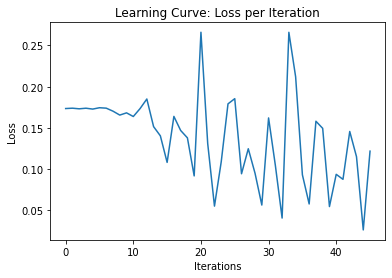

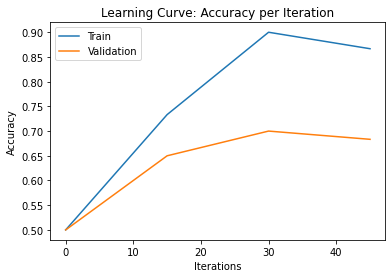

In [ ]:
cnn_memorize = CNNChannel() 
learning_curve_info = train_model(cnn_memorize,
                      train_data=train_data[:5],
                      validation_data=valid_data[:5],
                      batch_size=4,
                      learning_rate=0.002,
                      weight_decay=0.00001,
                      max_iters=45,
                      checkpoint_path='/content/gdrive/My Drive/Colab Notebooks/model parameters/cnn_memorize/ckpt-{}.pk')
plot_learning_curve(*learning_curve_info)

Iter 0. [Val Acc of pos 100%] [Val Acc of neg 0%] [Train Acc of pos 100%] [Train Acc of neg 0%] [Loss 0.692777]
Iter 15. [Val Acc of pos 13%] [Val Acc of neg 65%] [Train Acc of pos 20%] [Train Acc of neg 87%] [Loss 0.686475]
Iter 30. [Val Acc of pos 87%] [Val Acc of neg 38%] [Train Acc of pos 93%] [Train Acc of neg 67%] [Loss 0.667374]
Iter 45. [Val Acc of pos 88%] [Val Acc of neg 33%] [Train Acc of pos 87%] [Train Acc of neg 67%] [Loss 0.657596]
Iter 60. [Val Acc of pos 93%] [Val Acc of neg 35%] [Train Acc of pos 100%] [Train Acc of neg 73%] [Loss 0.612723]
Iter 75. [Val Acc of pos 95%] [Val Acc of neg 35%] [Train Acc of pos 100%] [Train Acc of neg 67%] [Loss 0.520567]


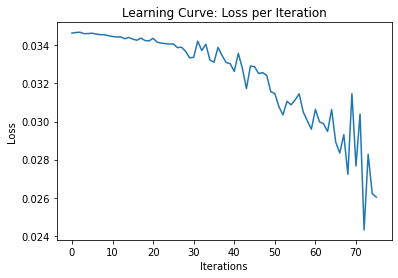

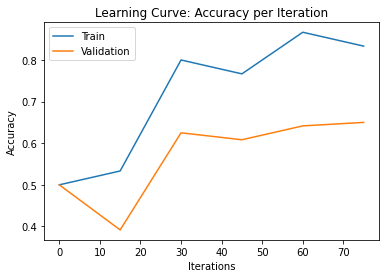

In [ ]:
cnn_memorize = CNN() 
learning_curve_info = train_model(cnn_memorize,
                      train_data=train_data[:5],
                      validation_data=valid_data[:5],
                      batch_size=20,
                      learning_rate=0.00016,
                      weight_decay=0.00002,
                      max_iters=75,
                      checkpoint_path='/content/gdrive/My Drive/Colab Notebooks/model parameters/cnn_memorize/ckpt-{}.pk')
plot_learning_curve(*learning_curve_info)

### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Explanation:**

We started with the second model. First, we tuned the learning rate to a value that we used in 3(b). We started with small batch size and determined all other parameters. Then, we tried using a different number of iterations (between 150-300), and we tried using small weight decay, around 0.0001. We understood that we get a higher score when using a bigger batch size. When we got to the general values, we tuned the batch size around 50 until we got a low loss and high train accuracy. In addition, we checked the validation accuracy to make sure there is no overfitting.

For the first model, we tuned the learning rate to a value which we used in 3(b), we understood that this model needs a lower learning rate compared to the second model. We modified the batch size following the second model we trained and used more iterations to get low loss and high accuracy. We didn't manage to lower the loss as low as we did for the second model, and that makes sense because the second model is better than the first.


In [ ]:
cnn_channel_train = CNNChannel()
learning_curve_cnn_channel = train_model(cnn_channel_train,
                      train_data=train_data,
                      validation_data=valid_data,
                      batch_size=60,
                      learning_rate=0.0015,
                      weight_decay=0.0002,
                      max_iters=150,
                      checkpoint_path='/content/gdrive/My Drive/Colab Notebooks/model parameters/cnnchannel/ckpt-{}.pk')

Iter 0. [Val Acc of pos 0%] [Val Acc of neg 100%] [Train Acc of pos 0%] [Train Acc of neg 100%] [Loss 0.692813]
Iter 25. [Val Acc of pos 68%] [Val Acc of neg 70%] [Train Acc of pos 67%] [Train Acc of neg 70%] [Loss 0.543920]
Iter 50. [Val Acc of pos 52%] [Val Acc of neg 93%] [Train Acc of pos 63%] [Train Acc of neg 93%] [Loss 0.440635]
Iter 75. [Val Acc of pos 97%] [Val Acc of neg 70%] [Train Acc of pos 94%] [Train Acc of neg 74%] [Loss 0.368155]
Iter 100. [Val Acc of pos 95%] [Val Acc of neg 73%] [Train Acc of pos 96%] [Train Acc of neg 78%] [Loss 0.270474]
Iter 125. [Val Acc of pos 88%] [Val Acc of neg 87%] [Train Acc of pos 92%] [Train Acc of neg 93%] [Loss 0.194041]
Iter 150. [Val Acc of pos 90%] [Val Acc of neg 75%] [Train Acc of pos 96%] [Train Acc of neg 87%] [Loss 0.134444]


In [ ]:
cnn_train = CNN()
learning_curve_cnn = train_model(cnn_train,
                      train_data=train_data,
                      validation_data=valid_data,
                      batch_size=60,
                      learning_rate=0.0002,
                      weight_decay=0.00002,
                      max_iters=350,
                      checkpoint_path='/content/gdrive/My Drive/Colab Notebooks/model parameters/cnn/ckpt3-{}.pk')

Iter 0. [Val Acc of pos 63%] [Val Acc of neg 37%] [Train Acc of pos 64%] [Train Acc of neg 38%] [Loss 0.692899]
Iter 50. [Val Acc of pos 100%] [Val Acc of neg 0%] [Train Acc of pos 100%] [Train Acc of neg 1%] [Loss 0.691901]
Iter 100. [Val Acc of pos 83%] [Val Acc of neg 25%] [Train Acc of pos 76%] [Train Acc of neg 45%] [Loss 0.655469]
Iter 150. [Val Acc of pos 75%] [Val Acc of neg 32%] [Train Acc of pos 68%] [Train Acc of neg 61%] [Loss 0.645103]
Iter 200. [Val Acc of pos 87%] [Val Acc of neg 27%] [Train Acc of pos 77%] [Train Acc of neg 60%] [Loss 0.653545]
Iter 250. [Val Acc of pos 95%] [Val Acc of neg 22%] [Train Acc of pos 90%] [Train Acc of neg 65%] [Loss 0.486265]
Iter 300. [Val Acc of pos 95%] [Val Acc of neg 27%] [Train Acc of pos 91%] [Train Acc of neg 86%] [Loss 0.281140]
Iter 350. [Val Acc of pos 88%] [Val Acc of neg 48%] [Train Acc of pos 85%] [Train Acc of neg 98%] [Loss 0.291261]


### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

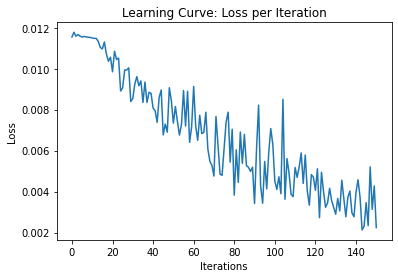

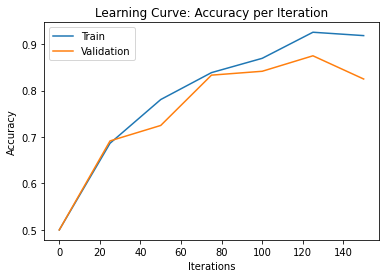

In [ ]:
plot_learning_curve(*learning_curve_cnn_channel)

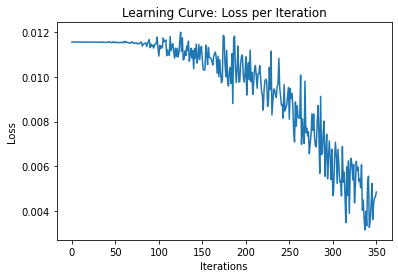

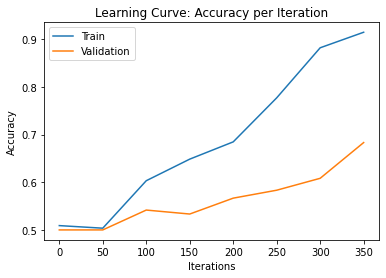

In [ ]:
plot_learning_curve(*learning_curve_cnn)

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
def get_accuracy_test(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns four
    separate values: the model accuracy on the positive samples,
    the model accuracy on the negative samples, and two lists, each containing the 
    prediction of the data images separately for positive and negative samples.
    """

    model.eval()
    n = data.shape[0]
    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pred_pos = []
    pred_neg = []
    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3)    # shape [n * 3, 3, 224, 448]
        xs = torch.transpose(xs,2,3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
        pred = pred.flatten()
        pred_pos.append(pred)
    pred_pos = np.array(pred_pos).flatten()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3)
        xs = torch.transpose(xs,2,3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()
        pred = pred.flatten()
        pred_neg.append(pred)
    pred_neg = np.array(pred_neg).flatten()
    return pos_correct / (n * 3), neg_correct / (n * 3), pred_pos, pred_neg, data_pos, data_neg

cnn_channel_train.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/model parameters/cnnchannel/ckpt-125.pk"))
a= get_accuracy_test(cnn_channel_train,test_m,10)
print("Test accuracy of positive samples for men test: ", a[0] * 100, "%")
print("Test accuracy of negative samples for men test: ", a[1] * 100, "%")
b= get_accuracy_test(cnn_channel_train,test_w,10)
print("Test accuracy of positive samples for women test: ", b[0] * 100, "%")
print("Test accuracy of negative samples for women test : ", b[1] * 100, "%")

Test accuracy of positive samples for men test:  76.66666666666667 %
Test accuracy of negative samples for men test:  83.33333333333334 %
Test accuracy of positive samples for women test:  90.0 %
Test accuracy of negative samples for women test :  90.0 %


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.


Predictions on shoes from the same pair for each image:  [1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1]
Predictions on shoes from differnet pair for each image:  [1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


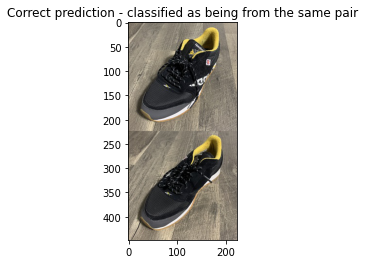

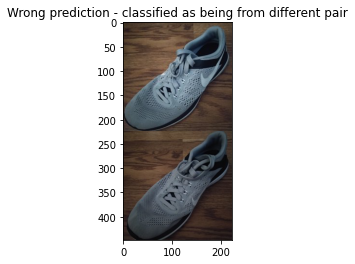

In [ ]:
print("Predictions on shoes from the same pair for each image: ", a[2])
print("Predictions on shoes from differnet pair for each image: ",a[3])
plt.figure()
plt.title('Correct prediction - classified as being from the same pair')
plt.imshow(a[4][0] + 0.5)
plt.figure()
plt.title('Wrong prediction - classified as being from different pair')
plt.imshow(a[4][6]+ 0.5)


### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

Predictions on shoes from the same pair for each image:  [1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predictions on shoes from differnet pair for each image:  [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


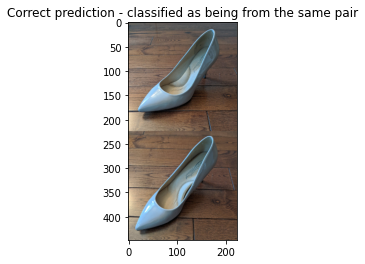

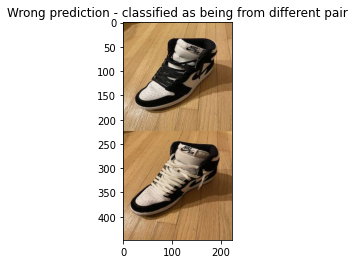

In [ ]:
print("Predictions on shoes from the same pair for each image: ", b[2])
print("Predictions on shoes from differnet pair for each image: ",b[3])
plt.figure()
plt.title('Correct prediction - classified as being from the same pair')
plt.imshow(b[4][0] + 0.5)
plt.figure()
plt.title('Wrong prediction - classified as being from different pair')
plt.imshow(b[4][6]+ 0.5)